In [1]:
#imports

import numpy as np
import shelve
from astropy.table import QTable
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const
from astropy.table import QTable
import os
import math
import shutil
from IPython.core.debugger import Tracer
import subprocess
import re
%matplotlib inline


#initial conditions
stable_ICs = shelve.open('stable_ICs')
ecc_b = stable_ICs['ecc_b']
ecc_c = stable_ICs['ecc_c']
semi_b = stable_ICs['semi_b']
semi_c = stable_ICs['semi_c']
dInc_b = stable_ICs['dInc_b']
dInc_c = stable_ICs['dInc_c']
dLongA_b = stable_ICs['dLongA_b']
dLongA_c = stable_ICs['dLongA_c']
dArgP_b = stable_ICs['dArgP_b']
dArgP_c = stable_ICs['dArgP_c']
mean_an_b = stable_ICs['mean_an_b']
mean_an_c = stable_ICs['mean_an_c']
good_hill = stable_ICs['good_hill']
bad_hill = stable_ICs['bad_hill']
dPrecA_b = stable_ICs['dPrecA_b']
dMass_star = stable_ICs['dMass_star']
dRadius_star = stable_ICs['dRadius_star']
dMass_b = stable_ICs['dMass_b']
dMass_c = stable_ICs['dMass_c']
dRadius_b = stable_ICs['dRadius_b']
dRadius_c = stable_ICs['dRadius_c']
dTidalQ_b = stable_ICs['dTidalQ_b']
dTidalQ_c = stable_ICs['dTidalQ_c']
dTidalQ_star = stable_ICs['dTidalQ_star']
dStopTime = stable_ICs['dStopTime']
stable_ICs.close()

In [2]:
#pulls finished data from local eqtide only runs

t = 25000 # number of sims



#finished data
data_merged_runs = np.array([])
data_age = np.array([])
data_semi = np.array([])
data_ecc = np.array([])
data_m_star = dMass_star
data_m_b = dMass_b
data_per = np.array([])


folders = np.array([]) # corresponding folders



n = 0
while n <= t-1:     # builds the final vars from output files
    name_idx = '%05i'%n
    folder_name = name_idx
    wd = './runs/'+folder_name
    fwd = open(wd+'/system.b.forward','r') #forward file
    fwd_content = fwd.read()
    fwd_content = fwd_content.split('\n') #split by line
    last_line = fwd_content[-2] #gets the last line of output, (last data before merge/completion)
    last_line = last_line.split(' ')
    max_age = last_line[0]
    max_age = float(max_age)
    str_max_age = str(max_age)
    str_max_age = str_max_age[0]
    sdigit_max_age = int(str_max_age)
    
    if max_age<=3e09: #throws away so able to generate age b/w 2 and 8 (excludes 2 and 2)
        data_merged_runs = np.append(data_merged_runs,int(folder_name))
    else:
        if max_age < 8e09: #generates age to max age
            age_rand = np.random.randint(2,sdigit_max_age)
            data_age = np.append(data_age,age_rand)
        
        elif max_age >= 8e09: #generates age 2 to 8 gyrs
            age_rand = np.random.randint(2,9)
            data_age = np.append(data_age,age_rand)

            
            
        line = fwd_content[age_rand]
        age = int(line[0])
        data = line.split(" ")
        ecc = float(data[2])
        semi = float(data[1])
        data_ecc = np.append(data_ecc,ecc)
        data_semi = np.append(data_semi,semi)
        #Tracer()()

    
    n += 1
data_m_star = np.delete(data_m_star,data_merged_runs)
data_m_b = np.delete(data_m_b,data_merged_runs)
data_m_b = abs(data_m_b)

data_m_star = data_m_star * u.solMass #solar mass
data_m_b = data_m_b * u.earthMass


a = data_semi * u.AU
per = np.sqrt(((4 * np.pi**2)/(const.G*(data_m_b + data_m_star)))*a**3)
per = per.decompose()
per = per.to(u.day)
per = per.value
data_per = per
# now to combine it all





In [3]:
data_semi = np.transpose(data_semi)
data_ecc = np.transpose(data_ecc)
data_age = np.transpose(data_age)
data_per = np.transpose(data_per)
data = np.vstack((data_age,data_semi,data_ecc,data_per))
data = np.transpose(data)
data.shape

(23248, 4)

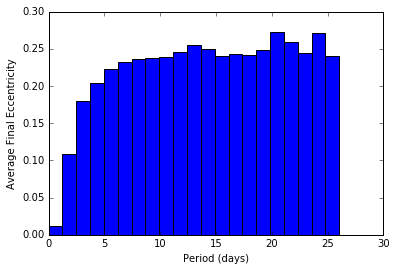

In [4]:
n = 20 #number of bins
binwidth = (max(data_per)-min(data_per))/n

#generate x axis'
x = np.arange(0,max(data_per),binwidth)
avg_ecc = np.array([])
#generate y axis, avg ecc per bin;



for l in x:
    
    lb = l
    ub = lb+binwidth
    ecc_bin = np.array([])
    
    for idx,per in enumerate(data_per):
        if per >= lb and per <= ub:
            ecc_bin = np.append(ecc_bin,data_ecc[idx])
            
    avg_ecc_bin = np.mean(ecc_bin)
    avg_ecc = np.append(avg_ecc,avg_ecc_bin)

    
x.shape,avg_ecc.shape,avg_ecc

fig,ax = plt.subplots(1,1)
ax.bar(x,avg_ecc,width=binwidth)
ax.set_xlabel('Period (days)')
ax.set_ylabel('Average Final Eccentricity')
        
    

In [5]:
# to find the run with the highest period:
print (np.argmax(data_per),data_per[np.argmax(data_per)])

22114 25.0646320901


In [18]:
# reads in table for completed hyak runs;
# completed.csv is from hyak, scp to local machine for updated list;
c = QTable.read('completed.csv',format='ascii.csv')

# define some masks for analysis 

max_mask = np.where(c['Runtime']==max(c['Runtime']))
avg_runtime = c['Runtime'].mean()
g_avg_mask = np.where(c['Runtime']>avg_runtime) # gives runtimes greater than average


g_day_mask = np.where(c['Runtime']>=86400) # 86400 is 1 day in seconds
print(c)
#c[max_mask]

 Sim #      Semi_b_0        Semi_c_0    ...     Mut Incl    Runtime
------- --------------- --------------- ... --------------- -------
    0.0  0.112429788685  0.446596378123 ...   2.90990362541  6261.0
    2.0 0.0881625872395  0.477645317707 ...   2.47073679276     0.0
    3.0  0.125030056458  0.564429693557 ... 0.0867552797444  1932.0
    4.0 0.0160630189595  0.202574579764 ...  0.781393895865     0.0
    5.0  0.044552272768  0.210879028953 ...    1.5799553008 55248.0
    6.0 0.0415138523983  0.328391948587 ...   2.38411854069   304.0
    7.0  0.122604036211  0.436838330153 ...   2.19240939708  5747.0
    8.0 0.0889901480746  0.245529202993 ...   2.84926426136 43656.0
    9.0    0.1042686931  0.662049018148 ...  0.560313295595     0.0
   10.0  0.113157897847  0.436021492191 ...   1.14071556815  7725.0
    ...             ...             ... ...             ...     ...
24988.0 0.0125278742763  0.336013860373 ...   2.86284111866   602.0
24989.0 0.0741700145946    0.3658368714 ...  0.2

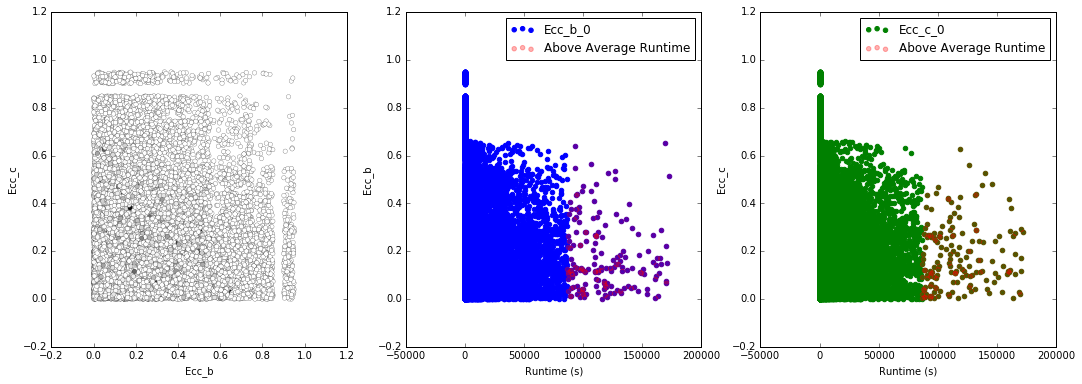

In [13]:
#need to grab the initial eccentricities for completed runs and compare with run time
fig,ax = plt.subplots(1,3)
fig.set_size_inches(18,6)

#plots ecc_b_0, ecc_c_0, and runtime

ax[0].scatter(c['Ecc_b_0'], c['Ecc_c_0'], c=c['Runtime'], cmap='Greys', linewidth=0.2)
ax[1].scatter(c['Runtime'],c['Ecc_b_0'],color='blue')
ax[2].scatter(c['Runtime'],c['Ecc_c_0'],color='green')

#identifies the runs that took longer than the average runtimes:

applied_mask = g_day_mask #from masks made in cell above
ax[1].scatter(c['Runtime'][applied_mask],c['Ecc_b_0'][applied_mask],color='red',alpha=0.3,label='Above Average Runtime')
ax[2].scatter(c['Runtime'][applied_mask],c['Ecc_c_0'][applied_mask],color='red',alpha=0.3,label='Above Average Runtime')

ax[0].set_ylabel('Ecc_c')
ax[0].set_xlabel('Ecc_b')

ax[1].set_ylabel('Ecc_b')
ax[1].set_xlabel('Runtime (s)')

ax[2].set_ylabel('Ecc_c')
ax[2].set_xlabel('Runtime (s)')

ax[1].legend(loc=0)
ax[2].legend(loc=0)

    

    

In [17]:
#avg_runtime
gt_avg_rt_mask = np.where(c['Runtime']>=avg_runtime) #86400s = 1 day; or use the average runtime;
lt_avg_rt_mask = np.where(c['Runtime']<avg_runtime)

avg_ecc_gt_b = c['Ecc_b_0'][gt_avg_rt_mask].mean()
avg_ecc_lt_b = c['Ecc_b_0'][lt_avg_rt_mask].mean()
print('Average Ecc_b_0 for sims w/ Runtime>avg_runtime',avg_ecc_gt_b,
      '\nAverage Ecc_b_0 for sims w/ Runtime<avg_runtime',avg_ecc_lt_b)

Average Ecc_b_0 for sims w/ Runtime>avg_runtime 0.198033077049 
Average Ecc_b_0 for sims w/ Runtime<avg_runtime 0.291385792181


In [16]:
# send rory case with large period, inputs
# see if longer runs have e > 0.22
# histogram of run times with freq (bins of runtime)
# ecc vs runtime
#np.argmax(data_per)


22114

In [ ]:
#continue hyak
#scatter plot of runtimes and ecc_b, ecc_c, initial. 


In [ ]:
#pull comp/uncomp ecc_c for 25000 hyak runs. 
#plot ecc_b, ecc_c, with color coded runtime. 
#highest runtime --> ecc of b and c? are they large?
#rad/per contour plot

In [ ]:
#determine which runs have been completed with eq_only and eq+distorb; see if any have merged with distorb.